<a href="https://colab.research.google.com/github/KalraA/ICS_635/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
%matplotlib inline
# Utilities
import numpy as np
np.random.seed(120) # reproducibility
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#SKLearn
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score


## Preparing Dataset

In [2]:
sklearn_dataset = load_breast_cancer()
X = sklearn_dataset.data
y = 1-sklearn_dataset.target

num_samples, num_features = X.shape
print("Total Number Samples:", num_samples)
print("Total Benign Samples:", (1-y).sum())
print("Total Malignant Samples:", y.sum())
print("Total Number of Features:", num_features)

class CrossValidationDataset:
  """A class to run cross validation on a dataset"""
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.inds = np.random.choice(len(X), len(X), replace=False)

  def get_split(self, current_split, total_splits):
    """
    Args:
      current_split: int - [0, total_splits-1], which of the current splits would you like
      total_splits: int - ( > 1), how many total splits of cross validation you want to do
    Returns:
      X_train, Y_train, X_test, y_test: The train / test splits
    """
    test_size = int(len(self.X)/total_splits)
    train_inds = np.concatenate([self.inds[:test_size*(current_split)+1],
                                 self.inds[test_size*(1+current_split):]])
    test_inds = self.inds[test_size*(current_split):test_size*(current_split+1)+1]
    return self.X[train_inds], self.y[train_inds], self.X[test_inds], self.y[test_inds]

dataset = CrossValidationDataset(X, y)
X_train, y_train, X_test, y_test = dataset.get_split(1, 5)

Total Number Samples: 569
Total Benign Samples: 357
Total Malignant Samples: 212
Total Number of Features: 30


In [3]:
from dataclasses import dataclass

from dataclasses import dataclass, field
from typing import Dict, Any

@dataclass
class Request:
    """Data class for requesting an experiment"""
    name: str = "N/A"
    params: Dict[str, Any] = field(default_factory=dict)
    scaling: bool = True

    def __repr__(self):
        return f"Request(name='{self.name}', params={self.params}, scaling={self.scaling})"

    def __str__(self):
        return f"Model: {self.name} \n Scaling: {self.scaling} \n Params: {self.params}"



class Metrics:
  """A helper class for storing metrics"""
  def __init__(self, request, y_pred, y_gt):
    self.request = request
    self.y_pred = y_pred
    self.y_gt = y_gt
    self.accuracy = accuracy_score(y_gt, y_pred)
    self.precision = precision_score(y_gt, y_pred)
    self.recall = recall_score(y_gt, y_pred)
    self.f1 = f1_score(y_gt, y_pred)

  def to_row(self):
    return dict(Model=self.request.name,
                Scaling=self.request.scaling,
                Params=str(self.request.params),
                accuracy=self.accuracy,
                precision=self.precision,
                F1=self.f1,
                recall=self.recall)

class Modeling:
  """A class to handle fitting different models."""
  def __init__(self, dataset, cross_validation=True):
    self.dataset = dataset
    self.splits = [0]
    if cross_validation:
      self.splits = [0, 1, 2, 3, 4]

  def run_experiment(self, request):
    model = self.get_model(request)
    y_pred, y_gt = self.run_model(model, scaling=request.scaling)
    metrics = Metrics(request, y_pred, y_gt)
    return metrics

  def get_model(self, request):
    model_name = request.name
    if model_name == 'knn':
      return  KNeighborsClassifier(**request.params)
    elif model_name == 'decision tree':
      return  DecisionTreeClassifier(random_state=0,
                                     **request.params)
    elif model_name == 'random forest':
      return  RandomForestClassifier(random_state=0,
                                     **request.params)
    else:
      raise ValueError(f'Invalid Request: Model {model_name} not found!')

  def run_model(self, model, scaling=False):
    y_preds = []
    y_gts = []
    for split in self.splits:
      X_train, y_train, X_test, y_test = dataset.get_split(split, 5)

      if scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      y_preds.append(y_pred)
      y_gts.append(y_test)
    return np.concatenate(y_preds), np.concatenate(y_gts)

  def run_experiments(self, experiments):
    metrics = [experiment_runner.run_experiment(request) for request in requests]
    dataframe = pd.DataFrame([x.to_row() for x in metrics])

    return metrics, dataframe



## Understanding the effect of Random Seed

In [4]:
# Cross Validation False
dfs = []
for seed in range(0, 10):
  np.random.seed(seed)
  dataset = CrossValidationDataset(X, y)
  experiment_runner = Modeling(dataset, cross_validation=False)
  requests = [Request('knn', {'n_neighbors': 5}, True),
              Request('decision tree', {}, False),
              Request('random forest', {'n_estimators': 100}, False)]
  metrics, df = experiment_runner.run_experiments(requests)
  dfs.append(df)

min_df = pd.concat(dfs).groupby(level=0).min()
max_df = pd.concat(dfs).groupby(level=0).max()
print("Min DF")
display(min_df)
print("Max DF")
display(max_df)

Min DF


,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,{'n_neighbors': 5},0.947368,0.941176,0.923077,0.875000
1,decision tree,False,{},0.859649,0.687500,0.804878,0.869565
2,random forest,False,{'n_estimators': 100},0.929825,0.825000,0.891892,0.880952


Max DF


,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,{'n_neighbors': 5},0.982456,1.000000,0.977778,0.956522
1,decision tree,False,{},0.956140,0.976744,0.938272,0.970588
2,random forest,False,{'n_estimators': 100},0.982456,1.000000,0.974359,0.970588


In [5]:
# Cross Validation True
dfs = []
for seed in range(0, 10):
  np.random.seed(seed)
  dataset = CrossValidationDataset(X, y)
  experiment_runner = Modeling(dataset, cross_validation=True)
  requests = [Request('knn', {'n_neighbors': 5}, True),
              Request('decision tree', {}, False),
              Request('random forest', {'n_estimators': 100}, False)]
  metrics, df = experiment_runner.run_experiments(requests)
  dfs.append(df)

min_df = pd.concat(dfs).groupby(level=0).min()
max_df = pd.concat(dfs).groupby(level=0).max()
print("Min DF")
display(min_df)
print("Max DF")
display(max_df)

Min DF


,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,{'n_neighbors': 5},0.961404,0.975000,0.945813,0.909953
1,decision tree,False,{},0.921053,0.884259,0.894614,0.891509
2,random forest,False,{'n_estimators': 100},0.952632,0.951456,0.935561,0.915094


Max DF


,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,{'n_neighbors': 5},0.971930,0.990050,0.961353,0.934272
1,decision tree,False,{},0.936842,0.922705,0.915888,0.920188
2,random forest,False,{'n_estimators': 100},0.964912,0.970000,0.952607,0.939252


## Default Comparison

In [6]:
# Cross Validation True
np.random.seed(0)
dataset = CrossValidationDataset(X, y)
experiment_runner = Modeling(dataset, cross_validation=True)
requests = [Request('knn', {'n_neighbors': 5}, True),
            Request('decision tree', {}, False),
            Request('random forest', {'n_estimators': 100}, False)]
metrics, df = experiment_runner.run_experiments(requests)
display(df)

,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,{'n_neighbors': 5},0.968421,0.985075,0.956522,0.929577
1,decision tree,False,{},0.929825,0.902326,0.906542,0.910798
2,random forest,False,{'n_estimators': 100},0.952632,0.951456,0.935561,0.920188


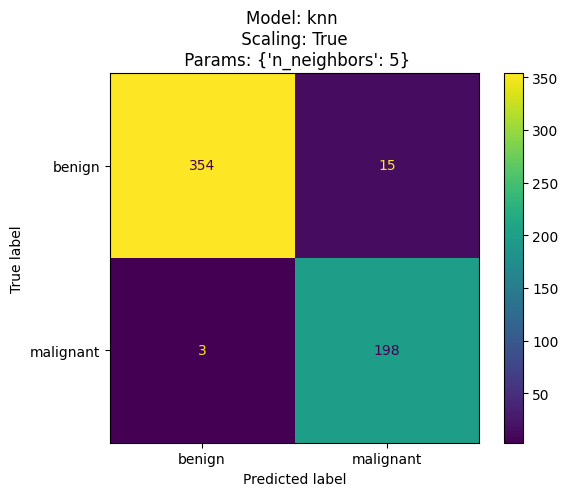

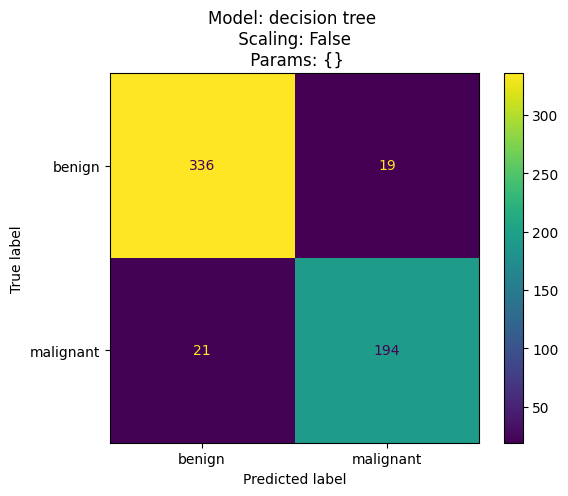

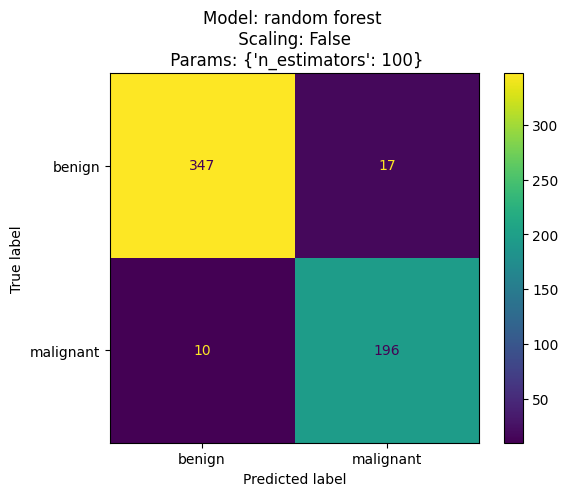

In [7]:
# Visualize Confusion Matrices
from sklearn.metrics import ConfusionMatrixDisplay
for metric in metrics:
  ConfusionMatrixDisplay.from_predictions(metric.y_pred, metrics[0].y_gt,
                                          display_labels=sklearn_dataset.target_names[::-1])
  plt.title(str(metric.request))
  plt.show()

## Ablation Studies

In [8]:
# Default Settings for all ablations
np.random.seed(0)
dataset = CrossValidationDataset(X, y)
experiment_runner = Modeling(dataset, cross_validation=True)


In [9]:
# S: Scaling
requests = [Request('knn', {'n_neighbors': 5}, True),
            Request('knn', {'n_neighbors': 5}, False),
            Request('decision tree', {}, True),
            Request('decision tree', {}, False),
            Request('random forest', {'n_estimators': 100}, True),
            Request('random forest', {'n_estimators': 100}, False)]
metrics, df = experiment_runner.run_experiments(requests)
display(df)

,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,{'n_neighbors': 5},0.968421,0.985075,0.956522,0.929577
1,knn,False,{'n_neighbors': 5},0.931579,0.922330,0.906921,0.892019
2,decision tree,True,{},0.929825,0.902326,0.906542,0.910798
3,decision tree,False,{},0.929825,0.902326,0.906542,0.910798
4,random forest,True,{'n_estimators': 100},0.952632,0.951456,0.935561,0.920188
5,random forest,False,{'n_estimators': 100},0.952632,0.951456,0.935561,0.920188


In [10]:
# A: KNN - Number of Neighbors
requests = [Request('knn', {'n_neighbors': n+1}, True) for n in range(12)]
metrics, df = experiment_runner.run_experiments(requests)
display(df)

,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,{'n_neighbors': 1},0.949123,0.946602,0.930788,0.915493
1,knn,True,{'n_neighbors': 2},0.957895,0.994764,0.940594,0.892019
2,knn,True,{'n_neighbors': 3},0.968421,0.989950,0.956311,0.924883
3,knn,True,{'n_neighbors': 4},0.963158,0.994845,0.948403,0.906103
4,knn,True,{'n_neighbors': 5},0.968421,0.985075,0.956522,0.929577
5,knn,True,{'n_neighbors': 6},0.961404,0.984772,0.946341,0.910798
6,knn,True,{'n_neighbors': 7},0.963158,0.980000,0.949153,0.920188
7,knn,True,{'n_neighbors': 8},0.961404,0.984772,0.946341,0.910798
8,knn,True,{'n_neighbors': 9},0.961404,0.979899,0.946602,0.915493
9,knn,True,{'n_neighbors': 10},0.959649,0.984694,0.943765,0.906103


In [11]:
# B: KNN - Power parameter for minowski (sklearn default param)
requests = [Request('knn', {'n_neighbors': 5, 'p': n+1},  True) for n in range(5)]
metrics, df = experiment_runner.run_experiments(requests)
display(df)

,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,"{'n_neighbors': 5, 'p': 1}",0.963158,0.980000,0.949153,0.920188
1,knn,True,"{'n_neighbors': 5, 'p': 2}",0.968421,0.985075,0.956522,0.929577
2,knn,True,"{'n_neighbors': 5, 'p': 3}",0.966667,0.980198,0.954217,0.929577
3,knn,True,"{'n_neighbors': 5, 'p': 4}",0.968421,0.980296,0.956731,0.934272
4,knn,True,"{'n_neighbors': 5, 'p': 5}",0.963158,0.975248,0.949398,0.924883


In [16]:
# C: Decision Tree - max depth
print("Decision Tree Max Depth Ablation")
requests = [Request('decision tree', {'max_depth': None},  True)] + [Request('decision tree', {'max_depth': 100000000000},  True)] + \
           [Request('decision tree', {'max_depth': n+1},  True) for n in range(10)]
metrics, df = experiment_runner.run_experiments(requests)
display(df)

Decision Tree Max Depth Ablation


,Model,Scaling,Params,accuracy,precision,F1,recall
0,decision tree,True,{'max_depth': None},0.929825,0.902326,0.906542,0.910798
1,decision tree,True,{'max_depth': 100000000000},0.929825,0.902326,0.906542,0.910798
2,decision tree,True,{'max_depth': 1},0.882456,0.872449,0.836186,0.802817
3,decision tree,True,{'max_depth': 2},0.912281,0.879070,0.883178,0.887324
4,decision tree,True,{'max_depth': 3},0.935088,0.927184,0.911695,0.896714
5,decision tree,True,{'max_depth': 4},0.936842,0.927536,0.914286,0.901408
6,decision tree,True,{'max_depth': 5},0.938596,0.923810,0.917258,0.910798
7,decision tree,True,{'max_depth': 6},0.931579,0.918269,0.907363,0.896714
8,decision tree,True,{'max_depth': 7},0.936842,0.919431,0.915094,0.910798
9,decision tree,True,{'max_depth': 8},0.936842,0.919431,0.915094,0.910798


In [13]:
# D: Random Forests - n_estimators
requests = [Request('random forest', {'n_estimators': n},  True) for n in [1, 5, 10, 25, 50, 100, 250, 500, 1000]]
metrics, df = experiment_runner.run_experiments(requests)
display(df)

,Model,Scaling,Params,accuracy,precision,F1,recall
0,random forest,True,{'n_estimators': 1},0.922807,0.896714,0.896714,0.896714
1,random forest,True,{'n_estimators': 5},0.950877,0.946860,0.933333,0.920188
2,random forest,True,{'n_estimators': 10},0.949123,0.964646,0.929440,0.896714
3,random forest,True,{'n_estimators': 25},0.954386,0.947368,0.938389,0.929577
4,random forest,True,{'n_estimators': 50},0.950877,0.951220,0.933014,0.915493
5,random forest,True,{'n_estimators': 100},0.952632,0.951456,0.935561,0.920188
6,random forest,True,{'n_estimators': 250},0.956140,0.951923,0.940618,0.929577
7,random forest,True,{'n_estimators': 500},0.956140,0.951923,0.940618,0.929577
8,random forest,True,{'n_estimators': 1000},0.954386,0.947368,0.938389,0.929577


In [14]:
# E: Random Forests - n_estimators
requests = [Request('random forest', {'n_estimators': 250, 'max_depth':None},  True)] + \
           [Request('random forest', {'n_estimators': 250, 'max_depth':10000000},  True)] + \
           [Request('random forest', {'n_estimators': 250, 'max_depth':n+1},  True) for n in range(10)]
metrics, df = experiment_runner.run_experiments(requests)
display(df)

,Model,Scaling,Params,accuracy,precision,F1,recall
0,random forest,True,"{'n_estimators': 250, 'max_depth': None}",0.956140,0.951923,0.940618,0.929577
1,random forest,True,"{'n_estimators': 250, 'max_depth': 10000000}",0.956140,0.951923,0.940618,0.929577
2,random forest,True,"{'n_estimators': 250, 'max_depth': 1}",0.924561,0.952128,0.892768,0.840376
3,random forest,True,"{'n_estimators': 250, 'max_depth': 2}",0.940351,0.936585,0.918660,0.901408
4,random forest,True,"{'n_estimators': 250, 'max_depth': 3}",0.954386,0.956098,0.937799,0.920188
5,random forest,True,"{'n_estimators': 250, 'max_depth': 4}",0.954386,0.951691,0.938095,0.924883
6,random forest,True,"{'n_estimators': 250, 'max_depth': 5}",0.952632,0.947115,0.935867,0.924883
7,random forest,True,"{'n_estimators': 250, 'max_depth': 6}",0.950877,0.946860,0.933333,0.920188
8,random forest,True,"{'n_estimators': 250, 'max_depth': 7}",0.954386,0.951691,0.938095,0.924883
9,random forest,True,"{'n_estimators': 250, 'max_depth': 8}",0.954386,0.947368,0.938389,0.929577


In [15]:
# Best Results
requests = [Request('knn', {'n_neighbors': 5}, True),
            Request('decision tree', {'max_depth': 5}, False),
            Request('random forest', {'n_estimators': 250}, False)]
metrics, df = experiment_runner.run_experiments(requests)
display(df)

,Model,Scaling,Params,accuracy,precision,F1,recall
0,knn,True,{'n_neighbors': 5},0.968421,0.985075,0.956522,0.929577
1,decision tree,False,{'max_depth': 5},0.938596,0.923810,0.917258,0.910798
2,random forest,False,{'n_estimators': 250},0.956140,0.951923,0.940618,0.929577
